Import các thư viện cần thiết:

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.optimizers import SGD
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Hàm để đọc dữ liệu tất cả ảnh có trong đường dẫn được truyền vào, đầu ra gồm ma trận mxn (m ảnh, n features) và mảng chứa class tương ứng với từng ảnh:

In [ ]:
ROWS = 150
COLUMNS = 150
CHANNELS = 3
# CHANNELS = 1


# Function to read image and convert to the specified size
def read_image(file_path):
    # return cv2.resize(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE), (ROWS, COLUMNS), cv2.INTER_AREA).flatten()
    return cv2.resize(cv2.imread(file_path, cv2.IMREAD_COLOR), (ROWS, COLUMNS), cv2.INTER_AREA).flatten()


def get_image_path(path):
    images = []
    categories = []

    # Get the list of class folders
    class_folders = os.listdir(path)

    # Iterate over each class folder
    for class_folder in class_folders:
        # Get the path to the current class folder
        class_folder_path = os.path.join(path, class_folder)

        # Get the list of image files in the class folder
        image_files = os.listdir(class_folder_path)

        # Iterate over each image file
        for image_file in image_files:
            # Get the path to the current image file
            image_file_path = os.path.join(class_folder_path, image_file)
            images.append(image_file_path)
            categories.append(class_folder)

    return images, categories


def get_data(path):
    images, categories = get_image_path(path)

    X = np.zeros((len(images), ROWS * COLUMNS * CHANNELS))

    for i, image_path in enumerate(tqdm(images)):
        X[i, :] = read_image(image_path)

    return X, np.array(categories)

Đọc dữ liệu training và validation:

In [ ]:
X_train, y_train = get_data('datav2/train/')
X_valid, y_valid = get_data('datav2/validation/')
X_test, y_test = get_data('datav2/test/')

100%|██████████| 996/996 [00:10<00:00, 92.89it/s] 


In [ ]:
X_train.shape

(5000, 67500)

In [ ]:
X_valid.shape

(2500, 67500)

In [ ]:
X_test.shape

(996, 67500)

1. Thực hiện thay đổi hợp lý trên giữ liệu, sau đó thực hiện việc rút gọn số chiều dữ liệu, sau đó tham khảo để hiển thị trực quan các phân lớp dữ liệu dạng 3D hoặc 2D. Đưa ra nhận xét về phân bố của tập dữ liệu cũng như cho biết lượng thông tin mất mát khi giảm chiều (theo cách đánh giá của phương pháp PCA).

Chuẩn hóa dữ liệu bằng cách thay đổi các giá trị điểm ảnh (khoảng 0-255) về khoảng 0-1

In [ ]:
# Standardizing the dataset
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)

Giảm số chiều xuống còn 2 chiều và hiển thị trực quan các phân lớp

In [ ]:
pca2d = PCA(n_components=2)
X_train_pca2d = pca2d.fit_transform(X_train)

# Print the amount of lost information
print("Lượng thông tin mất mát khi giảm chiều: {:.2f}%".format((1 - sum(pca2d.explained_variance_ratio_)) * 100))

Lượng thông tin mất mát khi giảm chiều: 58.08%


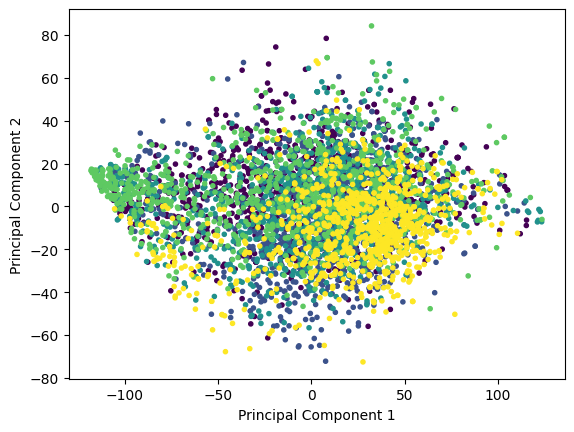

In [ ]:
# Create a scatter plot
plt.scatter(X_train_pca2d[:, 0], X_train_pca2d[:, 1], c=y_train_encoded, marker='.')

# Set plot title and labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()

3. Đưa dữ liệu về dạng ảnh 150x150pixels, sau đó giảm số chiều xuống còn 225 chiều bằng phương pháp phân tích thành phần chính PCA (lưu ý quy trình giảm chiều và sử dụng dữ liệu giảm chiều hợp lý). Xây dựng chương trình sử dụng mô hình ANN (mạng neural nhân tạo – dạng full connection) để phân loại các hình ảnh, huấn luyện mô hình bằng tập dữ liệu training sau đó chạy kiểm tra với dữ liệu trong tập validation.

Giảm số chiều dữ liệu xuống 225 chiều:

In [ ]:
# Create an instance of PCA with n_components=225
pca = PCA(n_components=225)

# Fit the PCA model to the data and transform the data
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Print the amount of lost information
print("Lượng thông tin mất mát khi giảm chiều: {:.2f}%".format((1 - sum(pca.explained_variance_ratio_)) * 100))

Lượng thông tin mất mát khi giảm chiều: 10.14%


In [ ]:
# Convert target to categorical format
y_train_categorical = to_categorical(y_train_encoded)
y_valid_categorical = to_categorical(y_valid_encoded)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [ ]:
train_pca_gen = DataGenerator(X_train_pca, y_train_categorical, 25)
valid_pca_gen = DataGenerator(X_valid_pca, y_valid_categorical, 25)
train_gen = DataGenerator(X_train, y_train_categorical, 25)
valid_gen = DataGenerator(X_valid, y_valid_categorical, 25)

Huấn luyện mô hình ANN với dữ liệu giảm chiều

Thử cải thiện mô hình ANN bằng cách thêm tầng ẩn, tăng số neutral:

In [ ]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Define the architecture of the ANN
model2 = Sequential([
    Dense(512, activation='relu', input_shape=(225,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 512)               115712    
                                                                 
 dense_128 (Dense)           (None, 256)               131328    
                                                                 
 dense_129 (Dense)           (None, 128)               32896     
                                                                 
 dense_130 (Dense)           (None, 5)                 645       
                                                                 
Total params: 280,581
Trainable params: 280,581
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(train_pca_gen, epochs=20, validation_data=valid_pca_gen, callbacks=[model_checkpoint_callback])

Epoch 1/20
200/200 [==============================] - 1s 5ms/step - loss: 1.8555 - accuracy: 0.3720 - val_loss: 1.4181 - val_accuracy: 0.4228
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 1.2126 - accuracy: 0.5050 - val_loss: 1.3678 - val_accuracy: 0.4244
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.9296 - accuracy: 0.6428 - val_loss: 1.4283 - val_accuracy: 0.4168
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.7416 - accuracy: 0.7154 - val_loss: 1.3298 - val_accuracy: 0.4964
Epoch 5/20
200/200 [==============================] - 1s 4ms/step - loss: 0.5881 - accuracy: 0.7928 - val_loss: 1.5232 - val_accuracy: 0.4780
Epoch 6/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3933 - accuracy: 0.8630 - val_loss: 1.4629 - val_accuracy: 0.5336
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.2289 - accuracy: 0.9268 - val_loss: 1.5605 - val_accuracy: 0.5456
Epoch 

In [ ]:
model2 = tf.keras.models.load_model(checkpoint_filepath)

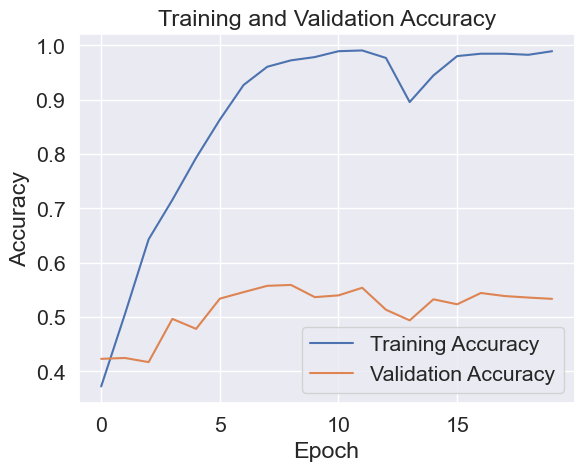

In [ ]:
plot_accuracy(history)

In [ ]:
y_pred = model_predict(model2, X_valid_pca)

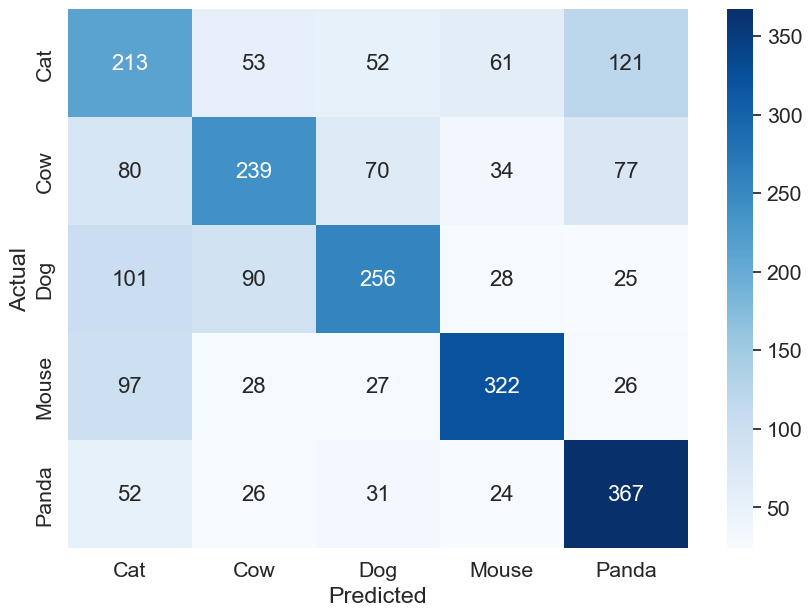

In [ ]:
plot_cf(y_valid, y_pred)

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         Cat       0.39      0.43      0.41       500
         Cow       0.55      0.48      0.51       500
         Dog       0.59      0.51      0.55       500
       Mouse       0.69      0.64      0.66       500
       Panda       0.60      0.73      0.66       500

    accuracy                           0.56      2500
   macro avg       0.56      0.56      0.56      2500
weighted avg       0.56      0.56      0.56      2500



Bổ sung thêm tầng Dropout:

In [ ]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

output

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 512)               115712    
                                                                 
 dropout_42 (Dropout)        (None, 512)               0         
                                                                 
 dense_132 (Dense)           (None, 256)               131328    
                                                                 
 dropout_43 (Dropout)        (None, 256)               0         
                                                                 
 dense_133 (Dense)           (None, 128)               32896     
                                                                 
 dropout_44 (Dropout)        (None, 128)               0         
                                                                 
 dense_134 (Dense)           (None, 5)               

In [ ]:
history = model3.fit(train_pca_gen, epochs=200, validation_data=valid_pca_gen, callbacks=[model_checkpoint_callback])

Epoch 1/200
200/200 [==============================] - 2s 6ms/step - loss: 2.9776 - accuracy: 0.2286 - val_loss: 1.5574 - val_accuracy: 0.2892
Epoch 2/200
200/200 [==============================] - 1s 5ms/step - loss: 1.7139 - accuracy: 0.2724 - val_loss: 1.5124 - val_accuracy: 0.3888
Epoch 3/200
200/200 [==============================] - 1s 5ms/step - loss: 1.5742 - accuracy: 0.3200 - val_loss: 1.4949 - val_accuracy: 0.3956
Epoch 4/200
200/200 [==============================] - 1s 4ms/step - loss: 1.4956 - accuracy: 0.3526 - val_loss: 1.4672 - val_accuracy: 0.3768
Epoch 5/200
200/200 [==============================] - 1s 4ms/step - loss: 1.4430 - accuracy: 0.3798 - val_loss: 1.4178 - val_accuracy: 0.3556
Epoch 6/200
200/200 [==============================] - 1s 5ms/step - loss: 1.3977 - accuracy: 0.3950 - val_loss: 1.3857 - val_accuracy: 0.4088
Epoch 7/200
200/200 [==============================] - 1s 4ms/step - loss: 1.3672 - accuracy: 0.4152 - val_loss: 1.3300 - val_accuracy: 0.4392

In [ ]:
model3 = tf.keras.models.load_model(checkpoint_filepath)

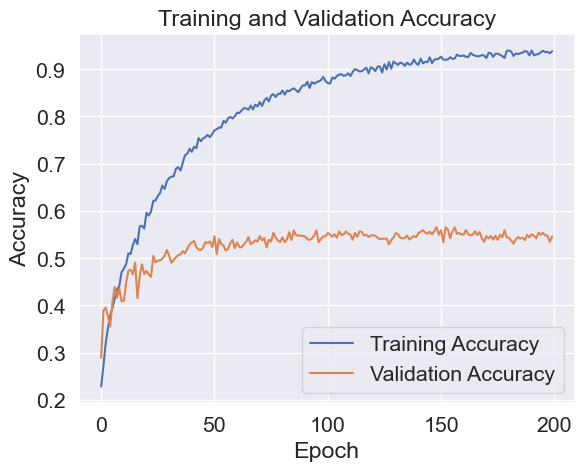

In [ ]:
plot_accuracy(history)

In [ ]:
y_pred = model_predict(model3, X_valid_pca)

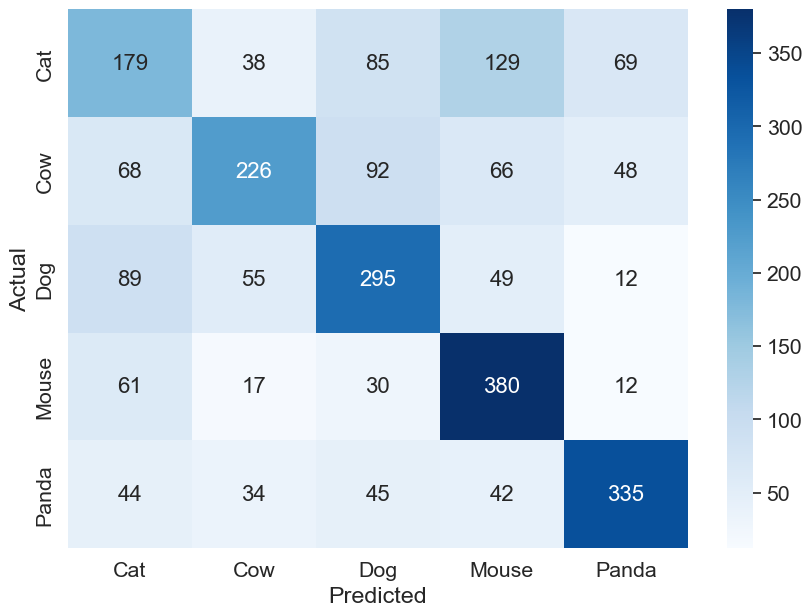

In [ ]:
plot_cf(y_valid, y_pred)

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         Cat       0.41      0.36      0.38       500
         Cow       0.61      0.45      0.52       500
         Dog       0.54      0.59      0.56       500
       Mouse       0.57      0.76      0.65       500
       Panda       0.70      0.67      0.69       500

    accuracy                           0.57      2500
   macro avg       0.57      0.57      0.56      2500
weighted avg       0.57      0.57      0.56      2500



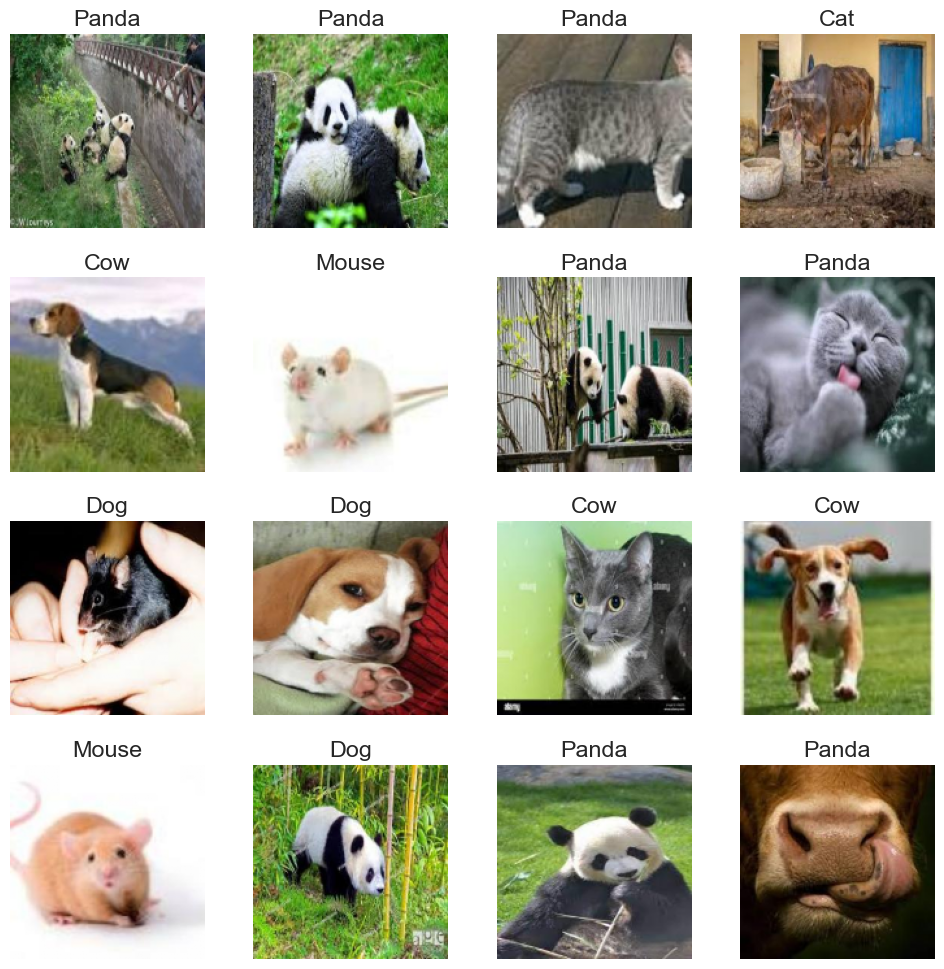

In [ ]:
plot_random_img_with_pred()

In [ ]:
pd.Series(y_test).value_counts()

Cat      394
Panda    237
Cow      177
Mouse    100
Dog       88
Name: count, dtype: int64

In [ ]:
# Create a list to store the accuracy scores
accuracy_scores = [accuracy_score(y_test, model_predict(model1, X_test_pca)),
                   accuracy_score(y_test, model_predict(model2, X_test_pca)),
                   accuracy_score(y_test, model_predict(model3, X_test_pca)),
                   accuracy_score(y_test, model_predict(model4, X_test)),
                   accuracy_score(y_test, model_predict(model5, X_test_pca))]

model_names = ['1st ANN', '2nd ANN', '3rd ANN', 'SM', 'SM PCA']

# Create a pandas dataframe to display the accuracy scores
df_accuracy = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy_scores})
df_accuracy

,Model,Accuracy
0,1st ANN,0.506024
1,2nd ANN,0.564257
2,3rd ANN,0.554217
3,SM,0.394578
4,SM PCA,0.407631
